# BBC News Classification with NMF Project

University of Colorado, Boulder - CSCA 5632: Unsupervised Algorithms in Machine Learning

## Project Overview

This project is about categorizing the BBC News articles using matrix factorization to predict the category. The project will work to follow a typical machine learning project, with an exception that the specific unsupervised model, Non-negative Matrix Factorization (NMF), is already determined. After evaluations have been perfomed for the NMF model, the project will then select and compare the performance for against a supervised model.

The code for this project can be found in my GitHubj [BBC_News](https://github.com/jfroggatt/BBC_News.git) repo.

The project notebook, [BBC News Classification with NMF](https://www.kaggle.com/code/jamesfroggatt/bbc-news-classification-with-nmf), can also be found on Kaggle, where the submission results for each of the three methods can be reviewed.

The guidelines for this project are as follows:

### Step 1. Exploratory Data Analysis

In this section we will inspect, visualize, and clean the data. As part of the process, we will also select a word embedding method and review associated visualizations and statistics. Following a review of the EDA, we will then generate a plan for the analysis, including data cleaning, preprocessing, and feature engineering steps.

### Step 2. Building and training the unsupervised model

In this section we will build a model using the Non-negative Matrix Factorization method and predict train and test data labels. The model's performance across various hyperparameter configurations will be evaluated to determine the optimal configuration. The performance will be inpected through results of the accuracy score and confusion matrix. Finally, we may look at additional methods to improve the final model performance.

### Step 3. Compare with supervised learning

In this section we will evaluate and select a supervised model to generate the predicted category and compare the test results with the NMF model. This comparison will also include an evaluation of how each model performs based on the size of the training data.

### Step 4. Project Report and Conclusion

Finally, we will evaluate the project results.

## Project Setup

### Python Project Libraries

Import the necessary libraries

In [1]:
from collections import Counter
import itertools
import numpy as np
import os
import pandas as pd
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as sqrf

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Download the following required data resources if not already downloaded and needed

# NLTK stopwords
nltk.download('stopwords', quiet=True)

# If using WordNetLemmatizer with POS tag support, you'll need the following NLTK data sets
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

# If using the spaCy lemmatizer, you'll need the following spaCy data set downloaded
#  for spaCy english words:
# !python -m spacy download en_core_web_sm


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
# list project data files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


### Load the data files

In [3]:
bbcnews_train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
bbcnews_test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
submission_sample = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

## Step 1. Exploratory Data Analysis (EDA)

#### Examine data sets

Let's take a look at the train, test, and sample submission data sets

In [4]:
print(f'Train data set: {bbcnews_train.shape}\n')
print(bbcnews_train.info())
bbcnews_train.head()

Train data set: (1490, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
print(f'Test data set: {bbcnews_test.shape}\n')
print(bbcnews_test.info())
bbcnews_test.head()

Test data set: (735, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [6]:
print(f'Sample submission data set: {submission_sample.shape}\n')
submission_sample

Sample submission data set: (735, 2)



,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


Confirmed that the training data has 1490 rows, containing no NaN/None/null values, and the following three columns:
* ArticleId - Article id, unique # given to the record
* Text - text of the header and article
* Category - cateogry of the article (tech, business, sport, entertainment, politics)

The test set has 735 rows, containing no NaN/None/null values, with the ArticleId and Text data, without the Category label. This is the data set that will be used for the submission.

The sample submission format inclcudes only the ArticleId and predicted Category.

### Explore distributions of data by category

In [7]:
# list categories and count for each
bbcnews_train.groupby('Category').count()

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


#### Let's generate some visualizations

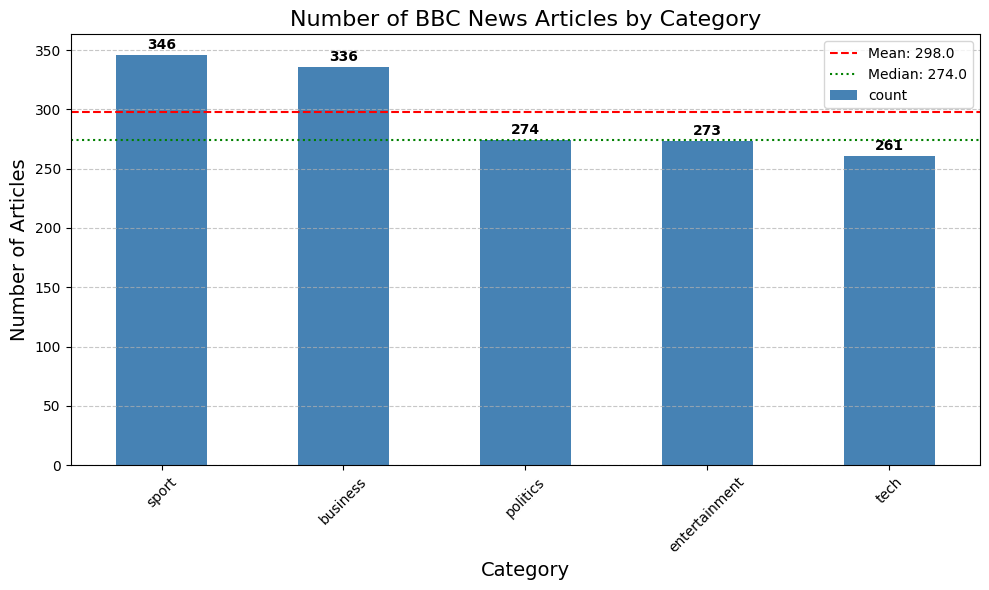

In [8]:
# Plot the number of articles in each category

# Get counts by categorry
category_counts = bbcnews_train['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = category_counts.plot(kind='bar', color='steelblue')

# Add horizontal lines for mean and median
mean_count = category_counts.mean()
median_count = category_counts.median()
ax.axhline(y=mean_count, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_count:.1f}')
ax.axhline(y=median_count, color='green', linestyle=':', linewidth=1.5, label=f'Median: {median_count:.1f}')

plt.title('Number of BBC News Articles by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Add the counts on top of each bar
for i, category_count in enumerate(category_counts):
    plt.text(i, category_count + 5, str(category_count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


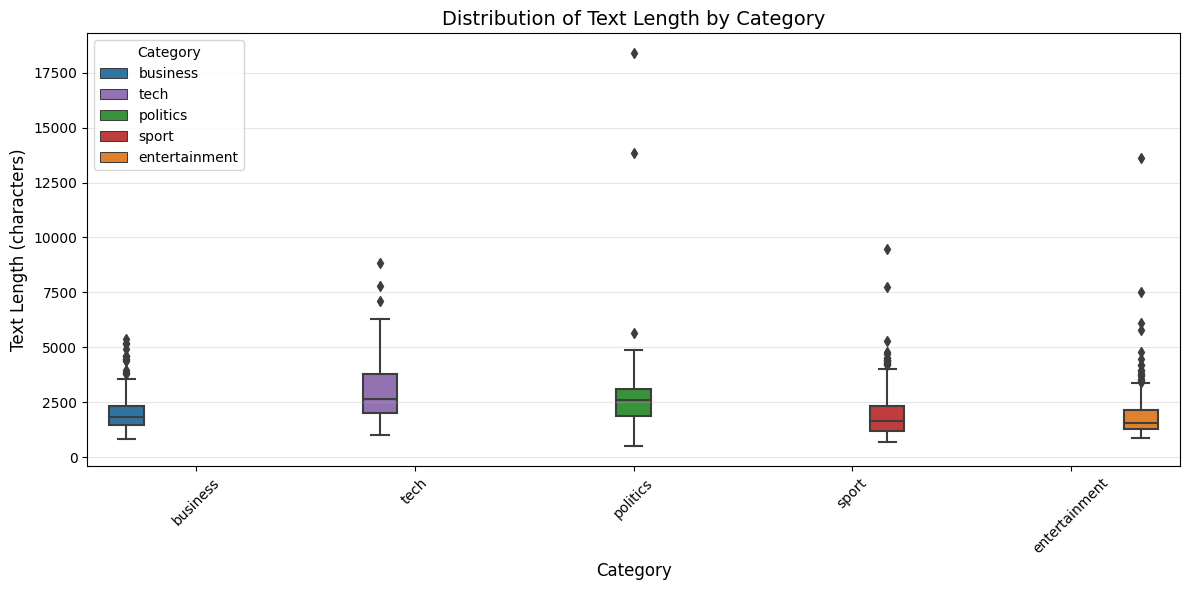

In [9]:
# Distribution of article length by category

# Calculate the length for each article
bbcnews_train['text_length'] = bbcnews_train['Text'].apply(len)

# Create a box plot to compare text length by category
category_colors = {
    'business': '#1f77b4',      # blue
    'entertainment': '#ff7f0e', # orange
    'politics': '#2ca02c',      # green
    'sport': '#d62728',         # red
    'tech': '#9467bd'           # purple
}
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='text_length', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Text Length by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

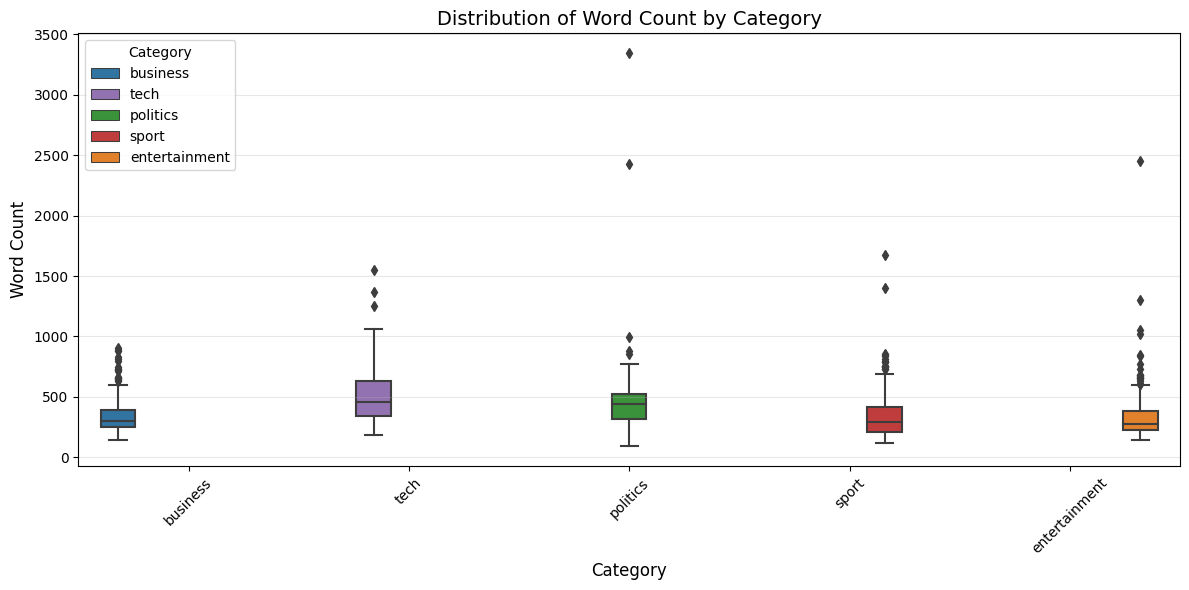

In [10]:
# Plot the distribution of word counts

# Calculate the word count for each article
bbcnews_train['word_count'] = bbcnews_train['Text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='word_count', data=bbcnews_train, palette=category_colors, hue='Category')
plt.title('Distribution of Word Count by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#### Let's explore the distribution of words across all articles

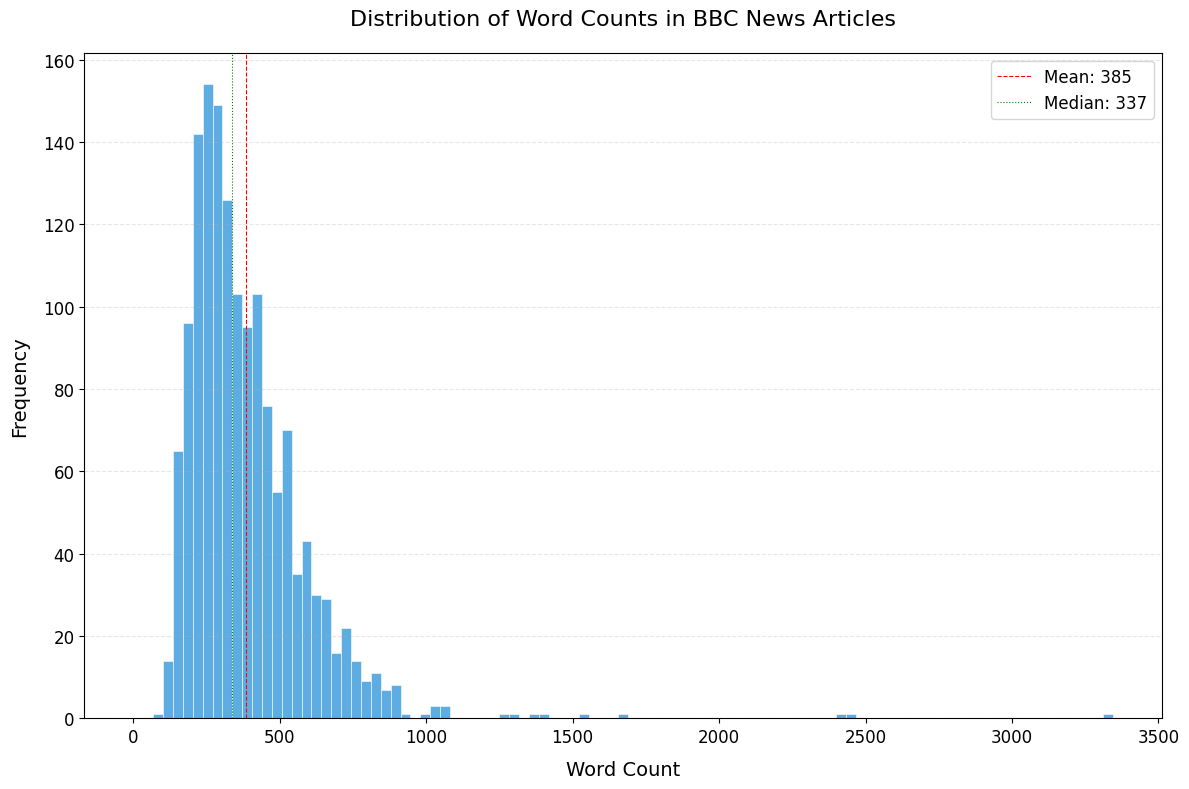

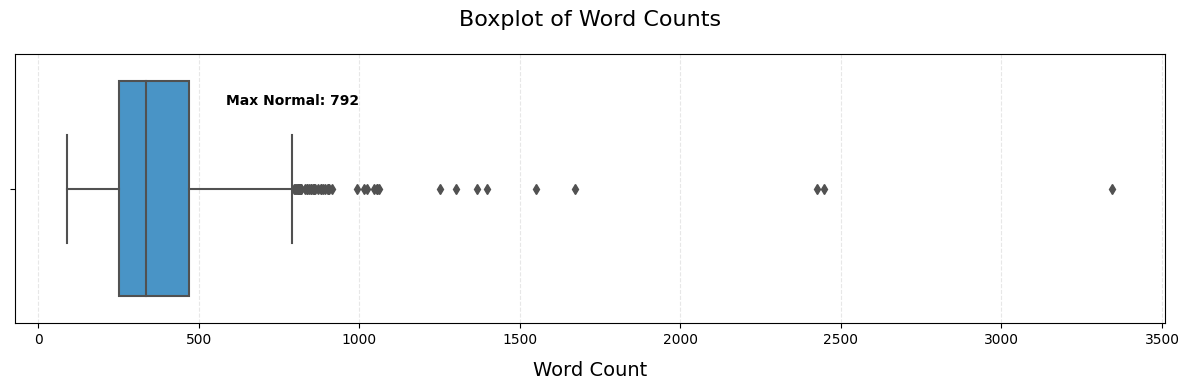

In [11]:
# The the distribution of the word count for all articles
plt.figure(figsize=(12, 8))

# Create the histogram of word counts
bins = np.linspace(0, bbcnews_train['word_count'].max(), 100)
n, bins, patches = plt.hist(bbcnews_train['word_count'], bins=bins,
                            color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.5)

# Calculate statistics
mean_val = bbcnews_train['word_count'].mean()
median_val = bbcnews_train['word_count'].median()
mode_val = bbcnews_train['word_count'].mode()[0]
std_val = bbcnews_train['word_count'].std()

# Add vertical lines for mean and median (with thinner lines)
plt.axvline(x=mean_val, color='red', linestyle='--', linewidth=0.8, label=f'Mean: {mean_val:.0f}')
plt.axvline(x=median_val, color='green', linestyle=':', linewidth=0.8, label=f'Median: {median_val:.0f}')

plt.title('Distribution of Word Counts in BBC News Articles', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Associated boxplot for the word count distribution
plt.figure(figsize=(12, 4))
ax = sns.boxplot(x=bbcnews_train['word_count'], color='#3498db')

# Calculate and display whisker values
Q1 = bbcnews_train['word_count'].quantile(0.25)
Q3 = bbcnews_train['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Text annotations
plt.text(upper_whisker, -0.3, f'Max Normal: {upper_whisker:.0f}', ha='center', va='bottom', fontweight='bold')  # plot upper whisker
plt.title('Boxplot of Word Counts', fontsize=16, pad=20)
plt.xlabel('Word Count', fontsize=14, labelpad=10)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


The data looks to have some significant outliers, where the number of words in some articles exceed the max normal of 792. Given that these are news articles, a general principle in jouranlism is to provide the most newsworthy information (who, what, when, where, why) towards the beginning of the article (inverted pyramid structure). Based on this principle, we can likely truncate the longer articles and still retain the necessary text to categorize it appropriately. We can play with some options and compare the results.

### Check for duplicates

In [12]:
bbcnews_train.nunique()

ArticleId      1490
Text           1440
Category          5
text_length    1172
word_count      558
dtype: int64

It looks like we have 50 articles where the text is not unique. Let's explore that further.

In [13]:
# Find duplicate rows in the training dataset where 'Text' is not unique
train_duplicates = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Number of duplicate rows: {len(train_duplicates)}")
display(train_duplicates.sort_values(by='Text'))


Number of duplicate rows: 100


,ArticleId,Text,Category,text_length,word_count
494,1326,ask jeeves joins web log market ask jeeves has...,tech,2480,435
228,1098,ask jeeves joins web log market ask jeeves has...,tech,2480,435
1430,1042,aviator creator in oscars snub the man who s...,entertainment,2147,391
695,374,aviator creator in oscars snub the man who s...,entertainment,2147,391
443,1847,blind student hears in colour a blind studen...,tech,2172,397
...,...,...,...,...,...
1047,789,virus poses as christmas e-mail security firms...,tech,1733,285
1409,957,web radio takes spanish rap global spin the ra...,tech,4041,710
616,110,web radio takes spanish rap global spin the ra...,tech,4041,710
63,2017,what high-definition will do to dvds first it ...,tech,5101,901


Let's verify that articles with identical text is also labeled with the same category

In [14]:
# Group duplicates by Text and check if all rows in each group have the same Category
print("Analysis of duplicate texts in training dataset:")
for text_with_dups, text_categories in train_duplicates.groupby('Text'):
    dup_categories = text_categories['Category'].unique()
    if len(dup_categories) == 1:
        print(f"Text (truncated): '{text_with_dups[:50]}...' has {len(text_categories)} duplicates, all with category: {dup_categories[0]}")
    else:
        print(f"Text (truncated): '{text_with_dups[:50]}...' has {len(text_categories)} duplicates with different categories: {dup_categories}")

# Count how many duplicate texts have consistent vs inconsistent categories
same_category = 0
different_category = 0

for dup_text, dup_cat in train_duplicates.groupby('Text'):
    if len(dup_cat['Category'].unique()) == 1:
        same_category += 1
    else:
        different_category += 1

print(f"\nSummary:")
print(f"- Duplicate texts with the same category: {same_category}")
print(f"- Duplicate texts with different categories: {different_category}")

Analysis of duplicate texts in training dataset:
Text (truncated): 'ask jeeves joins web log market ask jeeves has bou...' has 2 duplicates, all with category: tech
Text (truncated): 'aviator  creator  in oscars snub the man who said ...' has 2 duplicates, all with category: entertainment
Text (truncated): 'blind student  hears in colour  a blind student ha...' has 2 duplicates, all with category: tech
Text (truncated): 'bortolami predicts dour contest italy skipper marc...' has 2 duplicates, all with category: sport
Text (truncated): 'britons fed up with net service a survey conducted...' has 2 duplicates, all with category: tech
Text (truncated): 'brown outlines third term vision gordon brown has ...' has 2 duplicates, all with category: politics
Text (truncated): 'california sets fines for spyware the makers of co...' has 2 duplicates, all with category: tech
Text (truncated): 'camera phones are  must-haves  four times more mob...' has 2 duplicates, all with category: tech
Text (tru

We found no article text duplicates with different categories, so we should just remove the duplicates. Let's take a quick look at the structure of an article.

In [15]:
print(f"Article[0]: {bbcnews_train['Text'][0]}\n")
print(f"Article[1]: {bbcnews_train['Text'][1]}\n")

Article[0]: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by world

### Analysis Plan

Based on the findings from the EDA analysis, we will perform the following actions in the preprocessing steps:

1. Delete duplicate rows,
2. Enable word count truncation limits within the text cleanup process,
3. Convert to lowercase (even though the viewed articles are already lowercase),
4. Remove punctuation,
5. Remove numbers/digits,
6. Remove standard english stopwords
7. Evaluate removing short words (length < 3 chars)

#### Unsupervised model

Since the unsupervised model, Non-negative Matrix Factorization (NMF), has been predetermined for the initial evaluation, we only plan to focus on the following aspects for tuning the prediction accuracy:

* Text Preprocessing - testing different options for tokenization and normalization (e.g., stemming/lemmatizing)
* Vectorizing - for this project we are vectorizing using the TD-IDF vectorizer
* Hyperparameter tuning - the project will leverage GridSearchCV to determine target hyperparameters for the final model

#### Supervised model

The final steps in the project will be to evaluate and select a supervised model to classify the category and then compare the results with the unsupervised approach. GridSearchCV will again be used to evaluate the different models and then tune the final supervised model. The following supervised learning models will be evaluated:

* Random Forests
* SVM (LinearSVC)
* LogisticRegression


## Step 1b. Data Preprocessing

Remove ~50 articles with duplicated text

In [16]:
# remove duplicates
bbcnews_train = bbcnews_train.drop_duplicates(subset = ['Text'], keep = 'first')
remaining_dups = bbcnews_train[bbcnews_train.duplicated(subset=['Text'], keep=False)]
print(f"Remaining duplicates in the training dataset: {len(remaining_dups)}")

Remaining duplicates in the training dataset: 0


### TextCleaner

Create a custom transformer to perform the cleaning, vectorization, and normalization functions on the article text. Using a custom transformer for the text cleanup enables use within a pipeline process. The text cleanup function supports the following Text Preprocessing methods:
* Simple Tokenization - split text into words
* spaCy Lemmitizer - spaCy library for tokenization and lemmatizing
* WordNet Lemmatizer - Simple tokenization with NLTK WordNet lemmatizing using part of speech (POS) tagging
* Snowball Stemmer - Simple tokenization with NLTK Snowball stemming

In [17]:
# Create a custom transformer to perform text cleanup (usable in pipeline later)
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, min_word_length=2, max_word_count=0, method='simple', additional_words=None, stop_words=None):
        self.min_word_length = min_word_length
        self.max_word_count = max_word_count
        self.method = method
        self.additional_words = additional_words
        self.stop_words = stop_words

    def __getstate__(self):
        # Return state for pickling, excluding unpickleable objects
        state = self.__dict__.copy()
        return state

    def __setstate__(self, state):
        # Restore state from pickle
        self.__dict__.update(state)
        # Recreate remove_words_ if it exists
        if hasattr(self, 'remove_words_'):
            self._create_remove_words()

    # empty fit function to support use in pipeline
    def fit(self, X, y=None):
        # Initialize the remove_words set when fitting
        self._create_remove_words()
        return self

    # transform function for _cleanup_text to support use in pipeline
    def transform(self, X):
        if not hasattr(self, 'remove_words_'):
            self._create_remove_words()

        if hasattr(X, 'apply'):
            return X.copy().apply(self._cleanup_text)
        else:
            return [self._cleanup_text(text) for text in X]

    # function to generate the remove_words_ set
    def _create_remove_words(self):
        # Create a local stop_words variable - don't modify self.stop_words
        if self.stop_words is None:
            stop_words = set(stopwords.words('english'))
        else:
            stop_words = set(self.stop_words)

        if self.additional_words:
            # Convert to list first, then back to set to avoid pickle issues
            combined = list(stop_words) + list(self.additional_words)
            self.remove_words_ = set(combined)
        else:
            self.remove_words_ = stop_words

    # Function to perform the text cleanup and stem/lemmatize as specified
    def _cleanup_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove punctuation
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove numbers
        text = re.sub(r'\d+', ' ', text)

        # Process words (lemmatize, removing stopwords and additional words supplied, short words, and extra spaces)
        match self.method:
            case 'wordnet':
                words = self._wordnet_lemma(text)
            case 'snowball':
                words = self._snowball_stemmer(text)
            case _:  # default to 'simple'
                words = self._simple_tokens(text)

        # Limit to max word count if specified
        if self.max_word_count > 0:
            words = words[:self.max_word_count]

        return ' '.join(words)

    # Simple word tokens, removing words in the remove_words list and short words
    def _simple_tokens(self, text):
        tokens = text.split()
        return [token for token in tokens if token not in self.remove_words_ and len(token) > self.min_word_length]

    # WordNetLemmatizer
    def _get_wordnet_pos(self, nltk_tag):
        # Map for most common matches on the first letter of the tag
        pos_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}

        # Map NLTK POS tags to WordNet POS tags
        if nltk_tag[0] in pos_map:
            return pos_map[nltk_tag[0]]
        elif nltk_tag in ('MD', 'TO'):  # Modal, infinitive marker
            return wordnet.VERB
        else:
             return wordnet.NOUN  # Default to Noun for other cases

    def _wordnet_lemma(self, text):
        # NLTK data needed for wordnet and pos_tag - see Imports
        lemmatizer = WordNetLemmatizer()
        tokens = self._simple_tokens(text)

        # Get POS (part of speech) tags
        tagged_tokens = pos_tag(tokens)

        # Lemmatize with POS tag
        lemmatized_words = []
        for word, tag in tagged_tokens:
            if word not in self.remove_words_ and len(word) > self.min_word_length:
                # Get the WordNet POS tag
                wordnet_pos = self._get_wordnet_pos(tag)

                # Lemmatize with the appropriate POS tag
                lemma = lemmatizer.lemmatize(word, wordnet_pos)
                lemmatized_words.append(lemma)

        return lemmatized_words

    # SnowballStemmer
    def _snowball_stemmer(self, text):
        stemmer = SnowballStemmer("english")
        tokens = self._simple_tokens(text)

        # apply stemming
        words = [stemmer.stem(word) for word in tokens]

        return words


### Quick evaluation on word tokenization

Using the TextCleaner transformer, we are going to perform a quick evaluation to see if there are any common words across all groups that could impact categorization

In [18]:
# Cleanup the article Text - default simple method
text_cleaner = TextCleaner(method = 'simple')
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])
print("Original Text: ", bbcnews_train['Text'][0], "\n\n")
print("Cleaned Text: ", bbcnews_train['Text_cleaned'][0])

Original Text:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by w

Let's find the most common words in each category, then across all categories

In [19]:
# Find most common words in each category and across categories

# Helper function to get the top N words from a category
def get_top_n_words(category, top_n=30):
    # Get the articles for the specified category
    category_data = bbcnews_train[bbcnews_train['Category'] == category]

    # Combine all cleaned text for this category
    all_words = ' '.join(category_data['Text_cleaned']).split()

    # Count word frequencies and get the top N
    top_words = Counter(all_words).most_common(top_n)

    return top_words


def get_top_m_common_words(top_m=30, top_n=100, sort_by='average'):
    # Get the top_n words for each category
    categories = bbcnews_train['Category'].unique()
    category_words = {}
    for category in categories:
        category_words[category] = dict(get_top_n_words(category, top_n))

    # Find common words in all categories
    common_words = set(category_words[categories[0]].keys())
    for category in categories[1:]:
        common_words = common_words.intersection(set(category_words[category].keys()))

    print(f"The number of common words in all categories is {len(common_words)}")

    # Get the counts for each word
    # Create a DataFrame with counts for each word in each category
    data = []
    for word in common_words:
        row = {'word': word}
        counts = []
        for cat in categories:
            count = category_words[cat][word]
            row[cat] = count
            counts.append(count)

        # Calculate statistics
        row['total_count'] = sum(counts)
        row['avg_count'] = np.mean(counts)
        row['min_count'] = min(counts)
        row['max_count'] = max(counts)
        row['std_dev'] = np.std(counts)
        row['cv'] = row['std_dev'] / row['avg_count'] if row['avg_count'] > 0 else 0  # Coefficient of variation

        data.append(row)
    result_df = pd.DataFrame(data)

    # Sort based on the specified method
    match sort_by:
        case 'total':
            result_df = result_df.sort_values('total_count', ascending=False)
        case 'min_count':
            result_df = result_df.sort_values('min_count', ascending=False)
        case 'consistency':
            result_df = result_df.sort_values('cv', ascending=True)  # Lower CV means more consistent across categories
        case _:  # default to 'average'
            result_df = result_df.sort_values('avg_count', ascending=False)

    result_df = result_df.reset_index(drop=True)

    # Return top m common words
    return result_df.head(top_m)


common_category_words = get_top_m_common_words(top_n=30)
display(common_category_words)

The number of common words in all categories is 6


,word,business,tech,politics,sport,entertainment,total_count,avg_count,min_count,max_count,std_dev,cv
0,said,1098,980,1412,629,576,4695,939.0,576,1412,309.373561,0.329471
1,would,309,290,685,233,135,1652,330.4,135,685,187.349513,0.567038
2,year,452,224,175,330,304,1485,297.0,175,452,95.263844,0.320754
3,also,279,310,298,212,267,1366,273.2,212,310,34.019994,0.124524
4,new,273,324,271,202,229,1299,259.8,202,324,41.739190,0.160659
5,one,183,314,185,261,259,1202,240.4,183,314,50.102295,0.208412


### Word Treemaps for each Category

Let's create word treemaps for each category to visualize the most common. We'll create a helper function to create the treemap and default to the top 30 words and iterate through each category passed.

In [20]:
# Create and display treemaps for the top words in each category

# Helper function to create treemaps for each category using squarify, since Plotly Express treemaps weren't displaying on Run
def create_category_treemaps(category_list, top_n=30):
    color_schemes = {
        'business': 'Blues',
        'entertainment': 'BuGn',
        'politics': 'Greens',
        'sport': 'Reds', 
        'tech': 'Purples'
    }
    
    # Create figure with space for colorbars
    fig = plt.figure(figsize=(14, 20))
    
    for i, category in enumerate(category_list):
        ax = plt.subplot(5, 1, i+1)  # create a 5 row, single column plot
        
        # Get data
        treemap_data = pd.DataFrame(get_top_n_words(category, top_n), columns=['word', 'count'])
        sizes = treemap_data['count'].tolist()
        labels = treemap_data['word'].tolist()
        
        # Create colors (fix deprecated get_cmap)
        cmap = plt.colormaps[color_schemes.get(category, 'Blues')]
        norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
        colors = [cmap(norm(size)) for size in sizes]
        
        # Create treemap (remove alignment parameters to avoid conflicts)
        sqrf.plot(
            sizes=sizes,
            label=[f"{label}\n{size}" for label, size in zip(labels, sizes)],  # Include counts
            alpha=1.0,
            color=colors,
            ax=ax,
            pad=0,
            text_kwargs={
                'fontsize': 9,
                # 'fontweight': 'normal'
            },
            # borders between squares
            bar_kwargs={
                'linewidth': 0.3,
                'edgecolor': 'black'
            }
        )
        
        # Update text colors to get appropriate white/black depending on darkness
        texts = ax.texts
        patches = ax.patches
        
        # Match texts to patches by index
        for idx, text_obj in enumerate(texts):
            if idx < len(colors):
                patch_color = colors[idx]
                
                # Calculate brightness using the RGB values
                r, g, b = patch_color[0], patch_color[1], patch_color[2]
                brightness = (r * 0.299 + g * 0.587 + b * 0.114)
                
                # Use white text on dark colors, black on light colors
                if brightness < 0.6:
                    text_obj.set_color('white')
                    # text_obj.set_weight('bold')  # Make white text bold for better visibility
                else:
                    text_obj.set_color('black')
        
        # Style subplot
        ax.axis('off')
        ax.set_title(f'Most Common Words in {category.capitalize()} Articles', fontsize=12, fontweight='bold', pad=15)
        
        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        # Position colorbar to the right of each subplot
        pos = ax.get_position()
        cbar_ax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.02, pos.height])
        cbar = plt.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Count', rotation=270, labelpad=15, fontsize=10)
    
    return fig

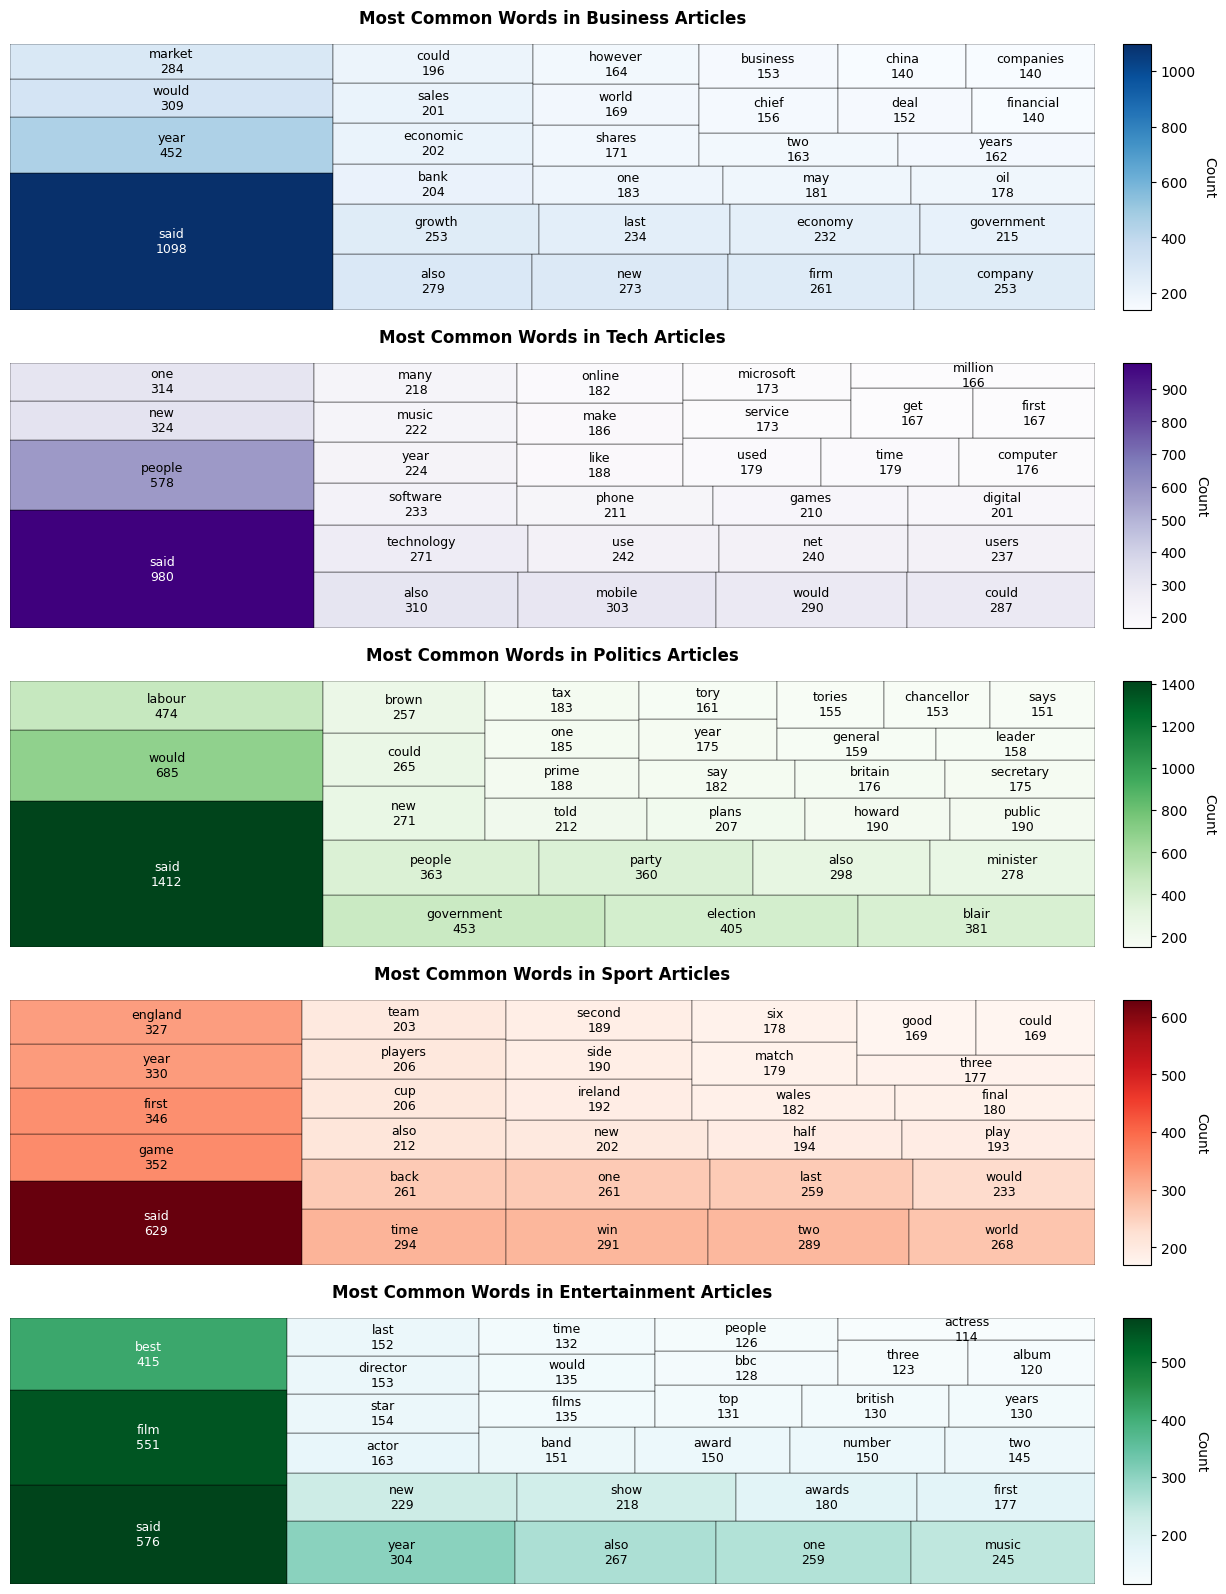

In [21]:
# Visualize the word treemap for each category 
treemap_fig = create_category_treemaps(bbcnews_train['Category'].unique())
treemap_fig.show()

### Remove Common Words

Looking at the six common words across all categories (said, would, year, also, new, one), and their prevalence within the top words, we will remove them from the text along with the standard stop words.

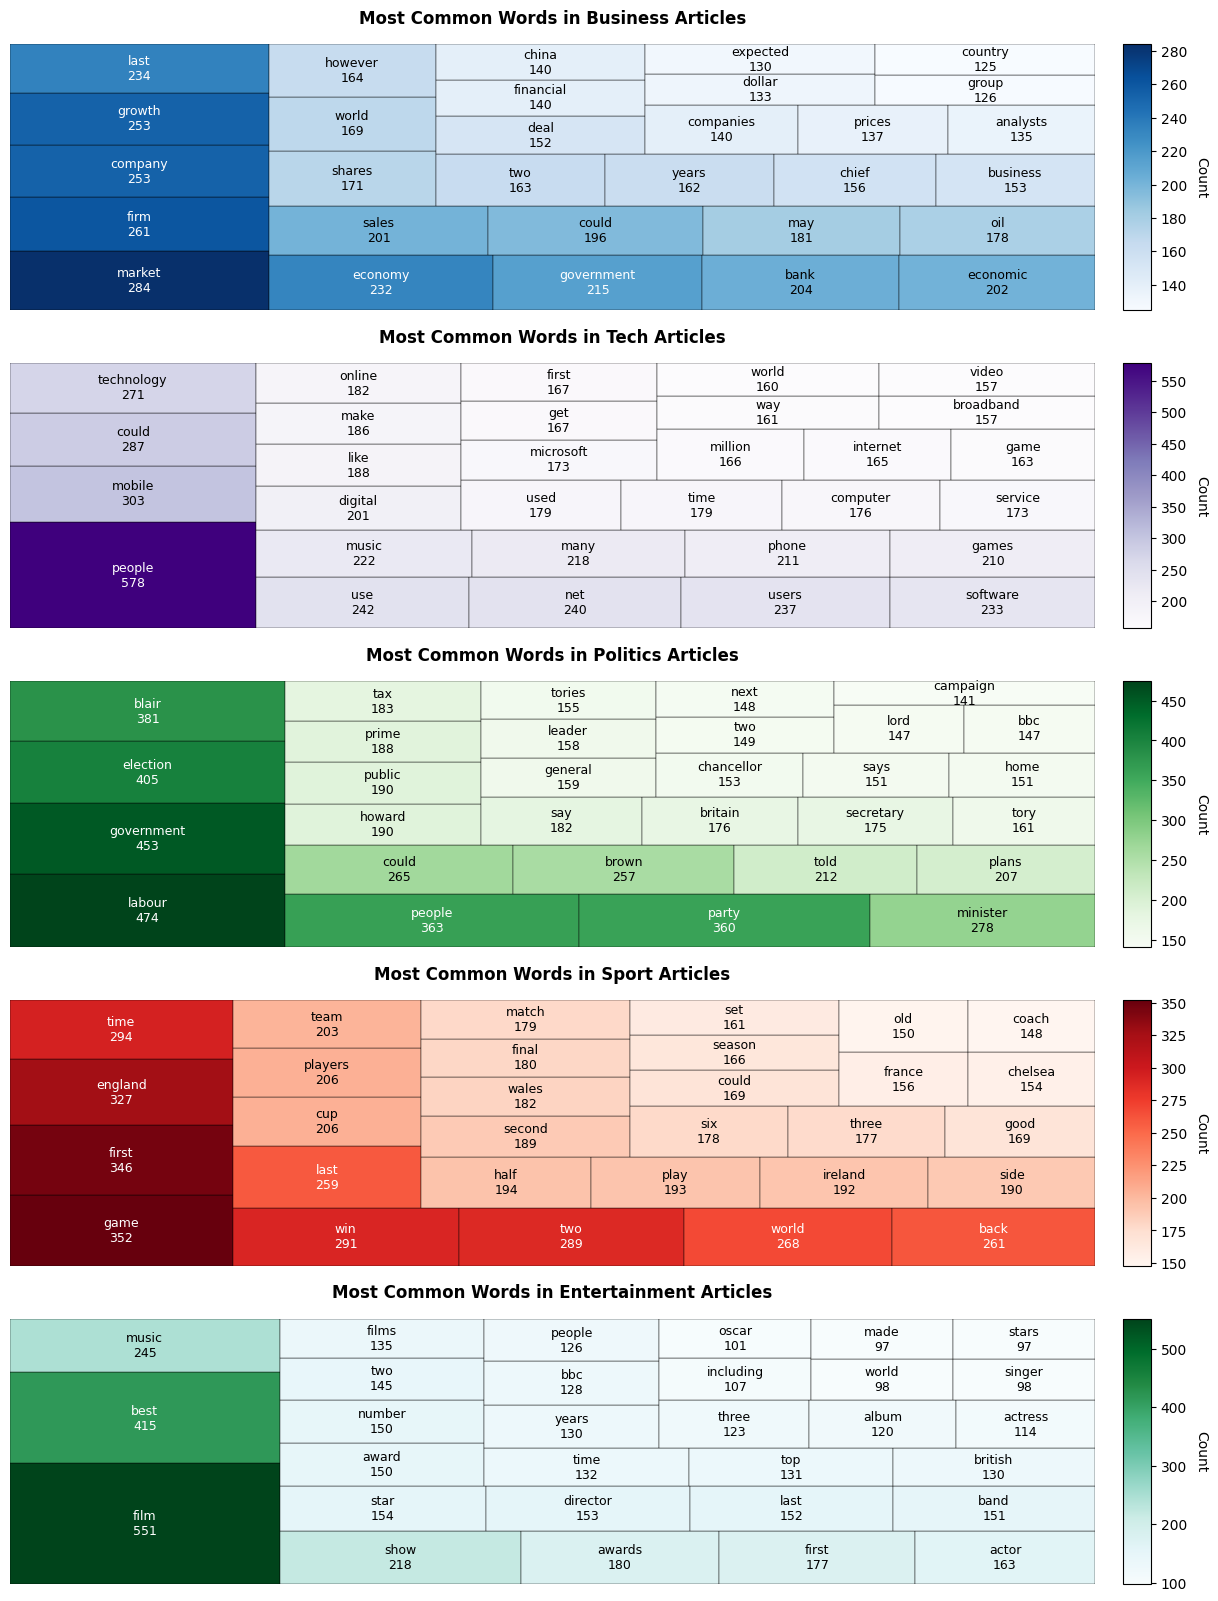

In [22]:
# Remove the common words from the word list
remove_common = common_category_words['word'].tolist()

# Cleanup the article Text
text_cleaner = TextCleaner(additional_words=remove_common)
bbcnews_train['Text_cleaned'] = text_cleaner.transform(bbcnews_train['Text'])

# Visualize the word treemaps with the common words removed
treemap_fig = create_category_treemaps(bbcnews_train['Category'].unique())
treemap_fig.show()

The word treemaps look better without the common words, especially given 'said' was the top word across all categories

## Step 1c. Create training and test data sets

In [23]:
# Split the current Train data set into a train and test sets to evaluate the models
X_train, X_test, y_train, y_test = train_test_split(
    bbcnews_train.Text,
    bbcnews_train.Category,
    test_size=0.2,
    random_state=42,
    stratify=bbcnews_train.Category  # Maintain class distribution
)
X_train.head()

587    blog  picked as word of the year the term  blo...
363    ronaldo considering new contract manchester un...
311    ask jeeves tips online ad revival ask jeeves h...
509    virus poses as christmas e-mail security firms...
441    google to scan famous libraries the libraries ...
Name: Text, dtype: object

## Step 2. Building and training the unsupervised model

Create a helper function to match prediction scores with category labels.  (re-using a function from a previous class module with some modification for the inital lable order and data types)

In [24]:
# Helper function to match categories with NMF results
def label_permute_compare(yt, yp, labels):
    # To support use in GridSearchCV/pipeline, need to handle the passed data formats
    # Make sure yt is a numpy array
    if isinstance(yt, pd.DataFrame):
        # Original data is a DataFrame input
        ytlist = yt.iloc[:, 0].to_numpy()
    elif isinstance(yt, pd.Series):
        # Cross-validation passes Series
        ytlist = yt.to_numpy()
    elif hasattr(yt, '__iter__') and not isinstance(yt, str):
        # List, array, or other iterable
        ytlist = np.array(list(yt))
    else:
        # Single value
        ytlist = np.array([yt])

    # Make sure yp is a numpy array)
    if isinstance(yp, pd.Series):
        yp = yp.to_numpy()
    elif not isinstance(yp, np.ndarray):
        yp = np.array(yp)

    # Both arrays should have the same length
    if len(ytlist) != len(yp):
        raise ValueError(f"yt (y_true) and yp (y_pred) must have same length. Got {len(ytlist)} and {len(yp)}")

    # Create permutations - only use as many as we have unique predicted values
    unique_predictions = len(np.unique(yp))
    labels_to_use = labels[:unique_predictions] if len(labels) >= unique_predictions else labels

    # Create a list of permutations for the labels
    perms = [list(perm) for perm in itertools.permutations(labels_to_use, len(labels_to_use))]

    # iterate through the permutations and calculate accuracy
    label_acc = []
    for perm in perms:
        try:
            # Create an array of labels for the prediction, using the permutation list and the cluster number as the index
            yp_labels = np.array(perm)[yp]
            # Get the accuracy score using the ground truth labels against this iteration of prediction labels
            accuracy = accuracy_score(ytlist, yp_labels)
            label_acc.append((accuracy, perm))
        except IndexError as e:
            # Handle case where yp has values outside the range of perm
            print(f"Warning: IndexError with permutation {perm}: {e}")
            continue

    # Handle issue with permutations
    if not label_acc:
        print("Warning: No valid permutations found, returning 0 accuracy")
        return tuple(range(len(labels))), 0.0

    # Get the results with the highest accuracy
    best_accuracy = max(label_acc, key=lambda x: x[0])

    # Map the best label order back to the original labels list for the permuted label order
    try:
        indices = [labels.index(label) for label in best_accuracy[1]]
        return tuple(indices), best_accuracy[0]
    except ValueError as e:
        print(f"Warning: Could not find all labels in original list: {e}")
        # Return default indices if mapping fails
        return tuple(range(len(best_accuracy[1]))), best_accuracy[0]


Create the pipeline for the process with an initial configuration for the text tokenizer, TF-IDF vectorizer, and NMF model.

In [25]:
# Create a pipeline to clean, transform, and vectorize the text and perform NMF
text_cleaner_simple = TextCleaner(method='simple', max_word_count=792, additional_words=remove_common)

tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    analyzer='word',
    ngram_range=(1, 2),
    sublinear_tf=True,
    token_pattern=r'\b\w+\b'
)

nmf_model = NMF(
    n_components=5,
    random_state=42,
    max_iter=300,
    solver='cd',
    beta_loss='frobenius',
    alpha_H=0.0,
    l1_ratio=0.5,
    init='nndsvd'
)

nmf_pipeline = Pipeline([
    ('text_cleaner', text_cleaner_simple),
    ('tfidf', tfidf_vectorizer),
    ('nmf', nmf_model)
])

Perform an initial run of the pipeline and check the resutls


Topics extracted from training data (top 10 words):
Topic #0: people mobile technology users phone use music software digital online
Topic #1: game england win side cup team first back play match
Topic #2: labour election blair government party minister prime minister prime tories tory
Topic #3: film best awards award actor films star oscar actress director
Topic #4: growth market economy economic shares bank firm company analysts prices


Train Accuracy: 0.9531


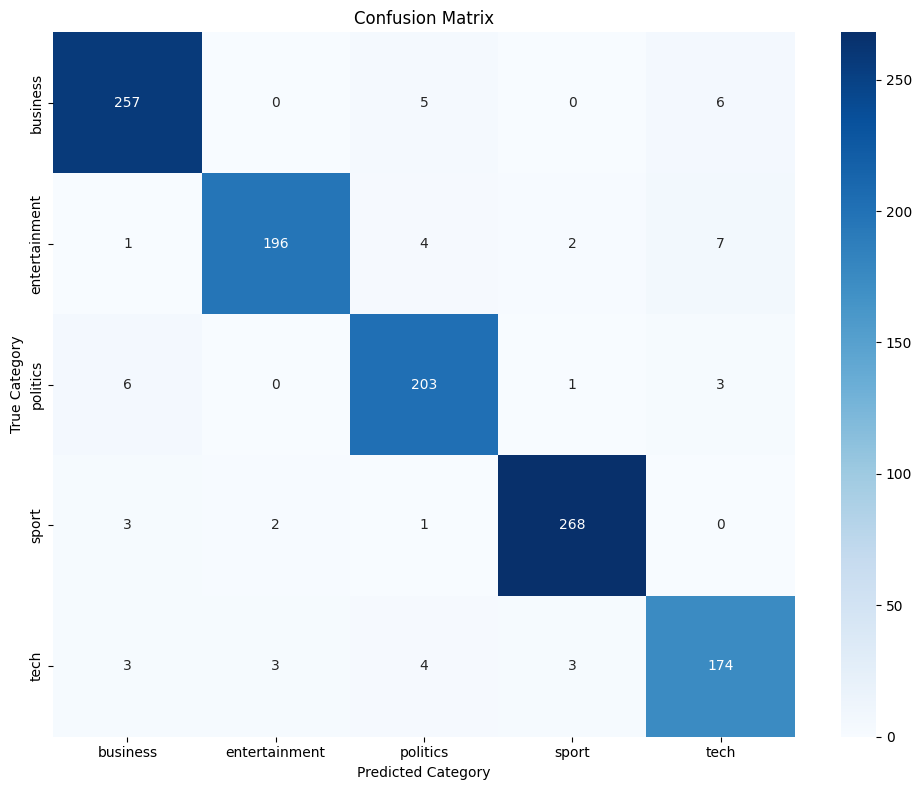

In [26]:
# Clean, transform, vectorize, and fit the article text
y_hat_train = nmf_pipeline.fit_transform(X_train)

# Assign the dominant topic as the prediction
y_pred = y_hat_train.argmax(axis=1)

# Extract and display topics
print("\nTopics extracted from training data (top 10 words):")
feature_names = nmf_pipeline.named_steps['tfidf'].get_feature_names_out()
for topic_idx, topic in enumerate(nmf_pipeline.named_steps['nmf'].components_):
    top_10_words_idx = topic.argsort()[:-11:-1]  # Get indices of top 10 words
    top_10_words = [feature_names[i] for i in top_10_words_idx]
    print(f"Topic #{topic_idx}: {' '.join(top_10_words)}")
print("\n")

# Get the category permutation mapping that achieves the highest accuracy for the clusters
base_category_list = np.unique(y_train).tolist()
topic_to_category_idx, accuracy = label_permute_compare(y_train, y_pred, base_category_list)
print(f"Train Accuracy: {accuracy:.4f}")

# Map the predicted topics to category names from the permutation results
category_mapping = {i: base_category_list[idx] for i, idx in enumerate(topic_to_category_idx)}

# Convert the topic numbers to category names
predicted_categories = [category_mapping[topic] for topic in y_pred]

# Create confusion matrix
cm = confusion_matrix(y_train, predicted_categories)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=base_category_list, yticklabels=base_category_list)
plt.title('Confusion Matrix')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()


### Setup GridSearchCV to tune model hyperparameters and generate the "best" model
* not including solver = 'cd', because it is not compatible with the other beta_loss functions and we can compare with above results
* including text transformation options for 'simple', 'wordnet', and 'snowball'
* not including init = 'nndsvd' as option, because it is not compatible with the other beta_loss functions

For the GridSearchCV process, we will:
* Create a custom scorer function to work with the NMF model and categorical response needed to determine the accuracy
* Perform a GridSearchCV process for the text transformer and TF-IDF vectorizer hyperparameters
* Perform a GridSearchCV process for the NMF model hyperparameters, using the best text transformer and TF-IDF vectorizer

In [27]:
# Create a wrapper class to support a customer scoring function for a pipeline/GridSearchCV since NMF doesn't support .predict()
def create_nmf_scorer(score_func):
    class NMFScorer:
        def __init__(self, score_func):
            self.score_func = score_func

        def __call__(self, estimator, X, y_true, sample_weight=None):
            return self.score_func(estimator, X, y_true)

    return NMFScorer(score_func)

# Create a custom scorer for GridSearchCV, using the label_permute_compare function
def nmf_category_scorer(estimator, X, y):
    # Get the transform for the current model
    doc_topic_matrix = estimator.transform(X)

    # Get dominant topic for each document
    predicted_topics = doc_topic_matrix.argmax(axis=1)

    # Use your label_permute_compare function
    labels = np.unique(y).tolist()
    indices, best_accuracy = label_permute_compare(y, predicted_topics, labels)

    return best_accuracy

# Initialize the custom scorer
category_scorer = create_nmf_scorer(nmf_category_scorer)

### Tune the Text Transformer and TF-IDF Vectorizer

Let's run a GridSearchCV process on the text transformation and TF-IDF vectorizer to find the "best" parameter configuration for our data. We'll just use the NMF model from above for this process.

In [28]:
# Use stratified K-fold to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grid for TF-IDF options
tfidf_param_grid = {
    'text_cleaner__method': ['simple', 'wordnet', 'snowball'],
    'tfidf__min_df': [3, 5, 10],  # Document frequency threshold
    'tfidf__max_df': [0.85, 0.9, 0.95],  # Ignore terms that appear too frequently
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, bigrams, and trigrams
    'tfidf__norm': ['l1', 'l2'],  # Normalization method
}

# Utilize caching to avoid processing times for recomputing text transformation on every iteration
from joblib import Memory
cache_dir = './cachedir'
os.makedirs(cache_dir, exist_ok=True)
memory = Memory(cache_dir, verbose=0)

# Create a pipeline
tfidf_pipeline = Pipeline([
    ('text_cleaner', text_cleaner_simple),
    ('tfidf', tfidf_vectorizer),
    ('nmf', nmf_model)
], memory=memory)

# Transform the text using the 'simple' transformer initialized above
X_train_simple = text_cleaner_simple.transform(X_train)

# Create GridSearchCV with the custom scorer and the current NMF model
run_NMF = True
if run_NMF:  # flag so that this isn't run on every version/submission
    tfidf_grid_search = GridSearchCV(
        tfidf_pipeline,
        param_grid=tfidf_param_grid,
        scoring=category_scorer,
        cv=cv,
        n_jobs=1,
        verbose=1
    )
    
    # Run grid search with the article text already transformed and vectorized
    tfidf_grid_search.fit(X_train_simple, y_train)
    
    print("\nBest score:", tfidf_grid_search.best_score_)
    print("Best_params:", tfidf_grid_search.best_params_)
else:
    print("skipping GridSearchCV for text transform and TF-IDF vectorizer, as it has already been run in a previous version.")
    
# Cleanup cache
memory.clear()

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best score: 0.9522454357236965
Best_params: {'text_cleaner__method': 'wordnet', 'tfidf__max_df': 0.85, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l2'}


### Tune NMF Hyperparameters

Now that we have the "best" configuration for the text transformer and TF-IDF vectorizer, let's setup and run GridSearchCV to find the best NMF model hyperparameters.

In [29]:
# Save the best text transformer options
best_text_cleaner = TextCleaner(method='wordnet', max_word_count=792, additional_words=remove_common)

# Update the TF-IDF vectorizer with the best options
best_tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    analyzer='word',
    ngram_range=(1, 2),
    norm='l2',
    sublinear_tf=True,
    token_pattern=r'\b\w+\b'
)

# Define parameter grid for the NMF model test options
nmf_param_grid = {
    'solver': ['mu'],
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'alpha_H': [0.0, 0.1, 0.5],
    'init': ['random', 'nndsvda', 'nndsvdar']
}

# Transform and vectorize the text
X_train_cleaned = best_tfidf_vectorizer.fit_transform(best_text_cleaner.transform(X_train))

# Create GridSearchCV with your custom scorer
if run_NMF:  # flag so that this isn't run on every version/submission
    nmf_grid_search = GridSearchCV(
        nmf_model,
        param_grid=nmf_param_grid,
        scoring=category_scorer,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    # Run grid search with the article text already transformed and vectorized
    nmf_grid_search.fit(X_train_cleaned, y_train)
    
    print("\nBest model:", nmf_grid_search.best_estimator_)
    print("Best score:", nmf_grid_search.best_score_)
    print("Best_params:", nmf_grid_search.best_params_)
else:
    print("skipping GridSearchCV for NMF hyperparameter optimization, as it has already been run in a previous version.")
    


Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best model: NMF(alpha_H=0.0, init='nndsvda', l1_ratio=0.5, max_iter=300, n_components=5,
    random_state=42, solver='mu')
Best score: 0.9461810653115
Best_params: {'alpha_H': 0.0, 'beta_loss': 'frobenius', 'init': 'nndsvda', 'solver': 'mu'}


### Train the "Best" NMF Model

Now we can save the "best" NMF model and run it against the test subset of the Train data.

Best Model Accuracy on the test subset: 0.9479


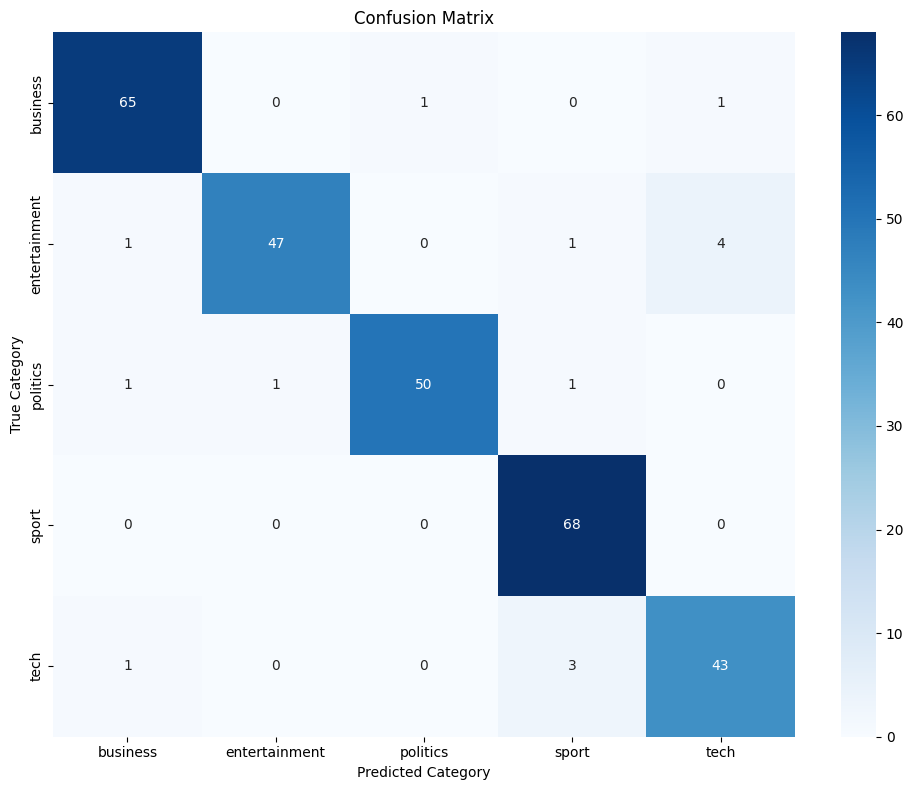

In [30]:
# Save the best estimator
best_nmf_model = NMF(
    n_components=5,
    random_state=42,
    max_iter=300,
    solver='mu',
    beta_loss='frobenius',
    alpha_H=0.0,
    l1_ratio=0.5,
    init='nndsvda'
)

# Create a pipeline with the best model
best_nmf_pipeline = (Pipeline([
    ('text_cleaner', best_text_cleaner),
    ('tfidf', best_tfidf_vectorizer),
    ('nmf', best_nmf_model)
]))

# Perform a fit_transform on the training data
y_hat_train = best_nmf_pipeline.fit_transform(X_train, y_train)
y_pred_train = y_hat_train.argmax(axis=1)

# Re-generate the category mapping, to make sure nothing has changed
topic_to_category_idx, accuracy = label_permute_compare(y_train, y_pred_train, base_category_list)
category_mapping = {i: base_category_list[idx] for i, idx in enumerate(topic_to_category_idx)}

# Run the best pipeline/model on the test subset of the Train data
y_hat = best_nmf_pipeline.transform(X_test)
y_pred = y_hat.argmax(axis=1)
y_pred_categories = [category_mapping[topic] for topic in y_pred]

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_categories)
print(f"Best Model Accuracy on the test subset: {test_accuracy:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_categories)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=base_category_list, yticklabels=base_category_list)
plt.title('Confusion Matrix')
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.show()

### Predict on Competition Test Data Set with NMF

Finally, generate a prediction on the competition Test data set using the best NMF model.

In [31]:
# Generate predictions for submission Test data set
nmf_test = bbcnews_test.copy()

# Predict the target category on the Test data set using the best nmf pipeline
y_hat_test = best_nmf_pipeline.transform(nmf_test['Text'])
y_pred = y_hat_test.argmax(axis=1)
y_pred_categories = [category_mapping[topic] for topic in y_pred]
nmf_test['Category'] = y_pred_categories

# drop unneeded columns
nmf_test = nmf_test.drop(['Text'], axis=1)
nmf_test.head(10)


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


... and create the prediction submission file.

In [32]:
%%script echo "skipping - not saving NMF results for this version"
# save submission for NMF model
try:
    nmf_test.to_csv('submission.csv', index=False)
    print("Submission file saved.")
except PermissionError:
    print("Could not write the submission file.")


skipping - not saving NMF results for this version


## Step 3. Compare with Supervised Learning

For this section, we will determine a "best" supervised learning model and then compare the results with the NFM unsupervised learning model. The supervised learning models that we will evaluate are:
* Support Vector Machine (SVM), using LinearSVC
* Logistic Regression
* Random Forest Classifier

We will use GridSearchCV to determine which model and hyperparameters perform the "best" for the comparison

In [33]:
# Base pipeline for testing the three models
classifier_pipeline = Pipeline([('classifier', LogisticRegression())])

# Support Vector Maching (SVM) model - LinearSVC
svm = LinearSVC(
    C=1.0,
    dual=False,
    loss='squared_hinge',
    class_weight=None,
    max_iter=10000            # increased due to failure to converge warnings
)

# Logistic Regression model
lr = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='liblinear',
    max_iter=10000,           # increased due to failure to converge warnings
    class_weight='balanced',
    random_state=42,
    multi_class='ovr'
)

# Random Forests Classifier model
rfc = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

classifier_param_grid = [
    {
        'classifier': [lr],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__penalty': ['l1', 'l2'],
    },
    {
        'classifier': [rfc],
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [None, 30, 50],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__class_weight': ['balanced', None],
    },
    {
        'classifier': [svm],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__class_weight': ['balanced', None],
    }
]

# Create GridSearchCV
run_Supervised = True  # ran GridSearchCV for Supervised model comparison in earlier Version
if run_Supervised:
    grid_search = GridSearchCV(
        classifier_pipeline,
        classifier_param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    # Run grid search with the article text already transformed and vectorized
    grid_search.fit(X_train_cleaned, y_train)
    
    print("\nBest model:", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    print("Best_params:", grid_search.best_params_)
else:
    print("skipping GridSearchCV for supervised learning model selection, as it has already been run in a previous version.")


Fitting 5 folds for each of 66 candidates, totalling 330 fits

Best model: Pipeline(steps=[('classifier',
                 LinearSVC(class_weight='balanced', dual=False,
                           max_iter=10000))])
Best score: 0.9765518539431582
Best_params: {'classifier': LinearSVC(class_weight='balanced', dual=False, max_iter=10000), 'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}


### Train/Test the Suppor Vector Machine (SVM) Model - LinearSVC

LinearSVC had the higher accuracy score of the three, so we save that model as the "best" supervised learning model and predict against the test subset data.

In [34]:
# Test the best SVM model on the test subset of the Train data
best_svm_model = LinearSVC(
    C=1.0,
    dual=False,
    loss='squared_hinge',
    class_weight='balanced',
    penalty='l2',
    max_iter=10000
)

best_svm_pipeline = Pipeline([
    ('text_cleaner', best_text_cleaner),
    ('tfidf', best_tfidf_vectorizer),
    ('svm', best_svm_model)
])

# Train the model
best_svm_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred_svm = best_svm_pipeline.predict(X_test)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy on test set: {accuracy_svm:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

Accuracy on test set: 0.9722

Classification Report:
               precision    recall  f1-score   support

     business       0.97      0.99      0.98        67
entertainment       0.96      0.96      0.96        53
     politics       0.98      0.96      0.97        53
        sport       0.99      1.00      0.99        68
         tech       0.96      0.94      0.95        47

     accuracy                           0.97       288
    macro avg       0.97      0.97      0.97       288
 weighted avg       0.97      0.97      0.97       288



### Predict on Competition Test Data Set with SVM

Next, we can use this model to generate a prediction on the competition Test data set.

In [35]:
# Generate predictions for submission Test data set
svm_test = bbcnews_test.copy()

# Predict the target category on the Test data set using the best nmf pipeline
svm_test['Category'] = best_svm_pipeline.predict(svm_test['Text'])

# drop unneeded columns
svm_test = svm_test.drop(['Text'], axis=1)
svm_test.head(10)


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


... and then save a corresponding submission file.

In [36]:
%%script echo "skipping - not saving SVM results for this version"
# save submission for SVM model
try:
    svm_test.to_csv('submission.csv', index=False)
except PermissionError:
    print("Could not write the submission file.")


skipping - not saving SVM results for this version


### NMF vs. SVM

Overall, it looks like the LinearSVC supervised learning model performed better on the category prediction over the Non-negative Matrix Factorization unsupervised model. In general, this makes sense, given that the supervised model can learn based on a known outcome, while the unsupervised model is clustering based on a determination of similarities/differences.

### Does training sample size matter?

For experimentation, we are going to compare the NMF and LinearSVC models across different training sample sizes. This will be done by creating splits for 20%, 40%, 60%, and 80%, running fit/predict for each model, and then comparing the results across each.

In [37]:
# Split the Train data set into different size train and test sets to evaluate supervised model(s)
splits = [0.2, 0.4, 0.6, 0.8]

# DataFrame to store results
split_results = pd.DataFrame(
    {
        'nmf': [0.0] * len(splits),
        'svm': [0.0] * len(splits)
    },
    index=splits
)
split_results.index.name = 'split'

# Iterate the test for each training set size
for split in splits:
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        bbcnews_train.Text,
        bbcnews_train.Category,
        test_size=split,
        random_state=42,
        # stratify=bbcnews_train.Category  # Maintain class distribution
    )

    # fit/predict for NMF
    y_hat_train_s = best_nmf_pipeline.fit_transform(X_train_s, y_train_s)
    y_pred_train_s = y_hat_train_s.argmax(axis=1)
    labels_s = np.unique(y_train_s).tolist()
    nmf_train_idx, nmf_train_accuracy = label_permute_compare(y_train_s, y_pred_train_s, labels_s)
    category_mapping_s = {i: labels_s[idx] for i, idx in enumerate(nmf_train_idx)}

    # Run on the test subset data for NMF
    y_hat_s = best_nmf_pipeline.transform(X_test_s)
    y_pred_s = y_hat_s.argmax(axis=1)
    y_pred_categories = [category_mapping_s[topic] for topic in y_pred_s]
    nmf_test_accuracy = accuracy_score(y_test_s, y_pred_categories)

    # Save results
    split_results.at[split, 'nmf'] = accuracy_score(y_test_s, y_pred_categories)

    # fit/predit for SVM
    best_svm_pipeline.fit(X_train_s, y_train_s)

    # Run on the test subset data for SVM
    y_pred_s = best_svm_pipeline.predict(X_test_s)
    split_results.at[split, 'svm'] = accuracy_score(y_test_s, y_pred_s)

split_results

,nmf,svm
split,,
0.2,0.947917,0.989583
0.4,0.960069,0.982639
0.6,0.946759,0.975694
0.8,0.940104,0.967014


Again, the LinearSVC supervised learning model had better accuracy than NMF across all variations of the split percentage.

### Ensemble Approach

For the final evaluation, let's see how an ensemble would work with both the NMF and LinearSVC models together. As an experiment, I will also add a Random Forest Classifier and test the voting weights to see the affects on the outcome. Instead of creating a custom transformer to enable NMF predictions, the NMF results were fed into a LogisticRegression classifier for the category prediction.

In [38]:
# Build an Ensemble that uses the NMF/Logistic Regression, SVM, and RFC models together

# Create a NMF-based classifier with LogisticRegression to generate predictions in a supervised learning process
nmf_classifier_pipeline = Pipeline([
    ('text_cleaner', clone(best_text_cleaner)),
    ('tfidf', clone(best_tfidf_vectorizer)),
    ('nmf_extractor', best_nmf_model),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Create a calibrated SVM classifier to return results in probability estimates
calibrated_svm_pipeline = Pipeline([
    ('text_cleaner', clone(best_text_cleaner)),
    ('tfidf', clone(best_tfidf_vectorizer)),
    ('svm', CalibratedClassifierCV(best_svm_model, cv=5))
])

# Create a calibrated Random Forest Classifier
calibrated_rfc_pipeline = Pipeline([
    ('text_cleaner', clone(best_text_cleaner)),
    ('tfidf', clone(best_tfidf_vectorizer)),
    ('rfc', CalibratedClassifierCV(rfc, cv=5))
])

# Create voting ensemble
ensemble = VotingClassifier(
    estimators=[
        ('nmf', nmf_classifier_pipeline),
        ('svm', calibrated_svm_pipeline),
        ('rfc', calibrated_rfc_pipeline)
    ],
    voting='soft',
    weights=[0.2, 0.4, 0.4]
)

# Fit the ensemble
ensemble.fit(X_train, y_train)

# Evaluate the model on test data
y_pred_ensemble = ensemble.predict(X_test)

# Calculate accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
print(f"Accuracy on test set: {accuracy_ensemble:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ensemble))

Accuracy on test set: 0.9618

Classification Report:
               precision    recall  f1-score   support

     business       0.97      0.99      0.98        67
entertainment       0.94      0.94      0.94        53
     politics       0.96      0.96      0.96        53
        sport       0.97      1.00      0.99        68
         tech       0.95      0.89      0.92        47

     accuracy                           0.96       288
    macro avg       0.96      0.96      0.96       288
 weighted avg       0.96      0.96      0.96       288



### Note on Voting Weights

Playing with the weight parameters, I found that the LinearSVC model still had the best accuracy and contributed the most to higher accuracy outcomes. The Random Forest Classifier also had a reasonable accuracy, with the NMF model seeming to contribute less towards the better prediction accuracies. In the end, the best prediction accuracy on the test subset data seemed to fall around 20%, 40%, 40% for NMF/LR, SVM, and RFC, respectively.

### Predict on Cempetition Test Data Set with Ensemble Method

In [39]:
# Generate predictions for submission Test data set
ensemble_test = bbcnews_test.copy()

# Predict the target category on the Test data set using the best nmf pipeline
ensemble_test['Category'] = ensemble.predict(ensemble_test['Text'])

# drop unneeded columns
ensemble_test = ensemble_test.drop(['Text'], axis=1)
ensemble_test.head(10)


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,entertainment
9,397,business


In [40]:
# save submission for SVM model
try:
    svm_test.to_csv('submission.csv', index=False)
except PermissionError:
    print("Could not write the submission file.")


## Conclusions

The project goals were to determine how well a Non-negative Matrix Factorization model would work on categorizing the BBC News Articles data in an unsupervised learning approach. We then wanted to run a supervised learning model against the same data set and examine how the results compared to the unsupervised model. For this step, we evaluated several supervised learning models and selected a SVM model (LinearSVC) as it had the highest accuracy scores. For additional experiments, we also ran tests to compare how the NMF and SVM models performed across various splits for the training data, to determine if that could be a factor for selecting the supervised versus unsupervised learning model approach. Finally, we generated an ensemble method, combining several models,to determine if that would benefit us for this data set.

Our final results...

For our final results, we used the WordNet text transformer and TF-IDF vectorizer, split the Train data into training and testing data sets, and used the same data sets to train/test all models/approaches. The project progressed from the unsupervised NMF model, to the supervised SVM (LinearSVC) model, and then to the supervised ensemble model, submitting competition results on the BBC News Train data set for each approach. The following were the Private/Public Score results:

* NMF:        0.94965 (Version 1 notebook)
* LinearSVC:  0.98503 (Version 3 notebook)
* Ensemble:   0.98503 (Version 6 notebook)

Based on the Test submission results, the LinearSVC SVM model performed consistently better throughout the process. The Ensemble method scored similarly, as it was likely influenced by the results generated from the LinearSVC component (40% voting weight).